In [1]:
import os 
import math
import random
import zipfile
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras import models
from DataUtils.DownloadCapuchin import download_dataset,parse_datasets
from IPython import display
from matplotlib import pyplot as plt
from pydub import AudioSegment, effects
from pydub.generators import WhiteNoise
from multiprocessing.pool import ThreadPool

In [2]:
download_dataset()
parse_datasets()

Finished Capuchinbird Call Download
Finished Other Sounds Download
Finished Capuchinbird Call Parsing
Finished Other Sounds Parsing


In [3]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
not_capuchin_files = os.listdir("Parsed_Not_Capuchinbird_Clips")
Capuchin_File = random.choice(capuchin_files)
Not_Capuchin_File = random.choice(not_capuchin_files)
print(f"Displaying {Capuchin_File} which is an example of a Parsed Capuchinbird Call:")
display.display(display.Audio(os.path.join("Parsed_Capuchinbird_Clips",Capuchin_File)))
print(f"Displaying {Not_Capuchin_File} which is an example of a Parsed Other Noise:")
display.display(display.Audio(os.path.join("Parsed_Not_Capuchinbird_Clips",Not_Capuchin_File)))

Displaying XC46077-1.wav which is an example of a Parsed Capuchinbird Call:


Displaying Crickets-chirping-5.wav which is an example of a Parsed Other Noise:


In [4]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary,desired_channels=1,)
    return tf.squeeze(audio, axis=-1)
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    return parts[-2]
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
    [16000] - tf.shape(waveform),
    dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
    equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [5]:
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)
warnings.simplefilter('ignore')

In [6]:
data_dir = os.getcwd()
commands = ["Parsed_Capuchinbird_Clips","Parsed_Not_Capuchinbird_Clips"]
filenames_Capuchinbird = tf.io.gfile.glob(str(data_dir) + '/Parsed_Capuchinbird_Clips/*')
filenames_Not_Capuchinbird = tf.io.gfile.glob(str(data_dir) + '/Parsed_Not_Capuchinbird_Clips/*')
filenames =tf.concat([filenames_Capuchinbird, filenames_Not_Capuchinbird], 0)
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)

Number of total examples: 810


2022-12-11 13:49:08.246954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-11 13:49:08.299586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ari/miniconda3/pkgs/cudnn-8.1.0.77-h90431f1_0/lib/libcudnn.so.8:/usr/local/cuda-11.7/lib64:
2022-12-11 13:49:08.299610: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-11 13:49:08.300523: I tensorflow/co

In [7]:
train_split = int(.8*num_samples)
val_split = int(.1*num_samples)
test_split = num_samples - train_split - val_split
train_files = filenames[:train_split]
val_files = filenames[train_split: train_split + val_split]
test_files = filenames[-1*test_split:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 648
Validation set size 81
Test set size 81


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

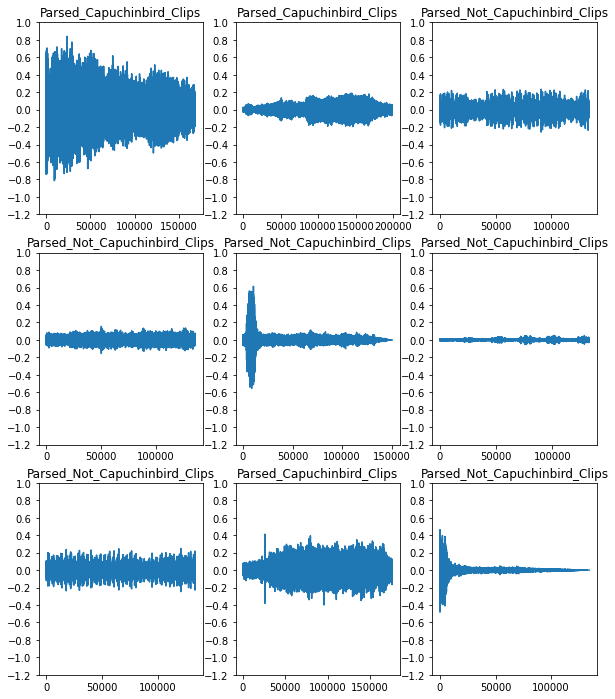

In [9]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [10]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
print('Spectrogram shape:', spectrogram.shape)

Spectrogram shape: (124, 129, 1)


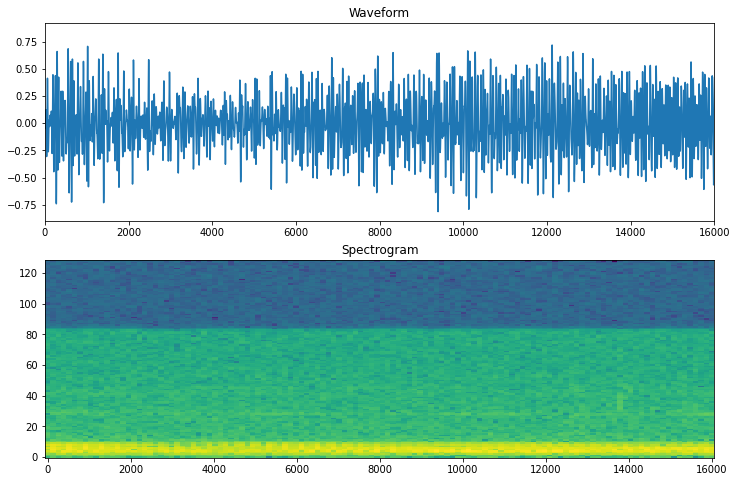

In [11]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

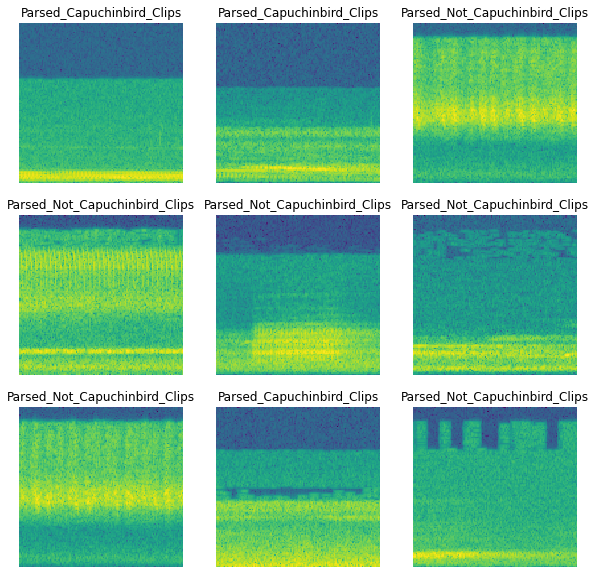

In [12]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

In [13]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [14]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='swish'),
    layers.Conv2D(64, 3, activation='swish'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='swish'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

cnn_model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [16]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 40
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=10,
                                               restore_best_weights=True
                                              ),
)

Epoch 1/40
11/11 [==============================] - 2s 140ms/step - loss: 0.5172 - accuracy: 0.7315 - val_loss: 0.4170 - val_accuracy: 0.8395
Epoch 2/40
11/11 [==============================] - 1s 60ms/step - loss: 0.3672 - accuracy: 0.8380 - val_loss: 0.4016 - val_accuracy: 0.8272
Epoch 3/40
11/11 [==============================] - 1s 61ms/step - loss: 0.3039 - accuracy: 0.8488 - val_loss: 0.3809 - val_accuracy: 0.8025
Epoch 4/40
11/11 [==============================] - 1s 59ms/step - loss: 0.2574 - accuracy: 0.8858 - val_loss: 0.3389 - val_accuracy: 0.8395
Epoch 5/40
11/11 [==============================] - 1s 60ms/step - loss: 0.2352 - accuracy: 0.9074 - val_loss: 0.4002 - val_accuracy: 0.8395
Epoch 6/40
11/11 [==============================] - 1s 57ms/step - loss: 0.2077 - accuracy: 0.9012 - val_loss: 0.4122 - val_accuracy: 0.8395
Epoch 7/40
11/11 [==============================] - 1s 60ms/step - loss: 0.1959 - accuracy: 0.9167 - val_loss: 0.4388 - val_accuracy: 0.8395
Epoch 8/40
1

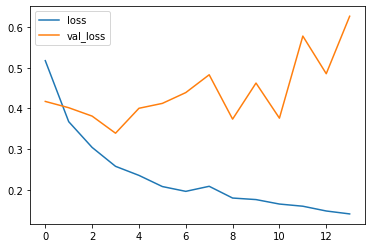

In [17]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [18]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(cnn_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


In [19]:
@tf.function
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav
def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label
def extract_embedding(wav_data, label):
    embeddings = vgg_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings)
           )
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=1842)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
tf.get_logger().setLevel('ERROR')

In [20]:
vgg_model_handle = 'https://tfhub.dev/google/vggish/1'
vgg_model = hub.load(vgg_model_handle)

In [21]:
capuchin_files = os.listdir("Parsed_Capuchinbird_Clips")
capuchin = []
for file in capuchin_files:
    if file.endswith('.wav'):
        capuchin.append(os.path.join("Parsed_Capuchinbird_Clips",file))
not_capuchin_files = os.listdir("Parsed_Not_Capuchinbird_Clips")
not_capuchin = []
for file in not_capuchin_files:
    if file.endswith('.wav'):
        not_capuchin.append(os.path.join("Parsed_Not_Capuchinbird_Clips",file))

In [22]:
capuchin_pd = pd.DataFrame({"filename":capuchin,"target":1})
not_capuchin_pd = pd.DataFrame({"filename":not_capuchin,"target":0})
dataset_pd = pd.concat([capuchin_pd,not_capuchin_pd],axis=0,ignore_index=True)
dataset_pd

,filename,target
0,Parsed_Capuchinbird_Clips/XC114131-0.wav,1
1,Parsed_Capuchinbird_Clips/XC114131-1.wav,1
2,Parsed_Capuchinbird_Clips/XC114131-2.wav,1
3,Parsed_Capuchinbird_Clips/XC114131-3.wav,1
4,Parsed_Capuchinbird_Clips/XC114131-4.wav,1
...,...,...
805,Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds...,0
806,Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds...,0
807,Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds...,0
808,Parsed_Not_Capuchinbird_Clips/tawny-owl-sounds...,0


In [23]:
main_ds = tf.data.Dataset.from_tensor_slices((dataset_pd["filename"], dataset_pd["target"]))
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

2022-12-11 13:50:11.154812: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [24]:
# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(128,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [25]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(main_ds,len(dataset_pd))

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [26]:
vgg_transfer_learning_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
], name='vgg_transfer_learning_model')

vgg_transfer_learning_model.summary()

Model: "vgg_transfer_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 67,074
Trainable params: 67,074
Non-trainable params: 0
_________________________________________________________________


In [27]:
vgg_transfer_learning_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [191]:
history = vgg_transfer_learning_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20


2022-12-10 22:22:31.181745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 382 of 10000
2022-12-10 22:22:41.198075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 770 of 10000
2022-12-10 22:22:51.212073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1148 of 10000
2022-12-10 22:23:01.152265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1523 of 10000
2022-12-10 22:23:11.218906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1904 of 10000
2022-12-10 22:23:21.168839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2286 of 10000


      1/Unknown - 65s 65s/step - loss: 0.5579 - accuracy: 0.8438

2022-12-10 22:23:25.518293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.
2022-12-10 22:23:25.518352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-12-10 22:23:25.518360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2 of 1000
2022-12-10 22:23:25.518363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 3 of 1000
2022-12-10 22:23:25.518366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4 of 1000
2022-12-10 22:23:25.518369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 5 of 1000
2022-12-10 22:23:25.518372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 6 of 1000
2022-12-1

21/21 [==============================] - 127s 3s/step - loss: 0.3779 - accuracy: 0.8333 - val_loss: 0.2300 - val_accuracy: 0.9136
Epoch 2/20
21/21 [==============================] - 0s 4ms/step - loss: 0.1842 - accuracy: 0.9290 - val_loss: 0.1665 - val_accuracy: 0.9383
Epoch 3/20
 1/21 [>.............................] - ETA: 0s - loss: 0.1149 - accuracy: 0.9688

2022-12-10 22:24:28.104929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


21/21 [==============================] - 0s 4ms/step - loss: 0.1343 - accuracy: 0.9491 - val_loss: 0.1391 - val_accuracy: 0.9630
Epoch 4/20
21/21 [==============================] - 0s 4ms/step - loss: 0.1075 - accuracy: 0.9676 - val_loss: 0.0990 - val_accuracy: 0.9630
Epoch 5/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0893 - accuracy: 0.9738 - val_loss: 0.0984 - val_accuracy: 0.9506
Epoch 6/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0776 - accuracy: 0.9784 - val_loss: 0.0760 - val_accuracy: 0.9630
Epoch 7/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 0.9799 - val_loss: 0.0692 - val_accuracy: 0.9753
Epoch 8/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0534 - accuracy: 0.9861 - val_loss: 0.0568 - val_accuracy: 0.9877
Epoch 9/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0415 - accuracy: 0.9877 - val_loss: 0.0478 - val_accuracy: 1.0000
Epoch 10/20
21/21 [============

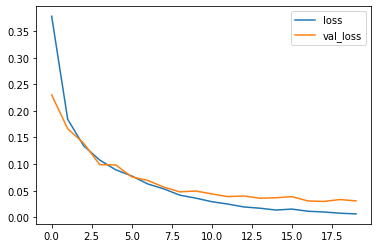

In [192]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [193]:
loss, accuracy = vgg_transfer_learning_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

2022-12-10 22:27:18.150737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 390 of 10000
2022-12-10 22:27:28.140082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 788 of 10000
2022-12-10 22:27:38.179401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1187 of 10000
2022-12-10 22:27:48.159235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1583 of 10000
2022-12-10 22:27:58.176632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1979 of 10000
2022-12-10 22:28:08.202010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 2343 of 10000


55/55 [==============================] - 63s 1ms/step - loss: 0.0446 - accuracy: 0.9867
Loss:  0.044592879712581635
Accuracy:  0.9867051839828491


2022-12-10 22:28:11.372624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


In [40]:
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

clip_names = os.listdir("Forest Recordings")
clip_names.sort()
counts = [0]*len(clip_names) 
for i, file in enumerate(clip_names): 
    file = f"Forest Recordings/{file}"
    print(file)
    testing_wav_data = load_mp3_16k_mono(file)
    embeddings = vgg_model(testing_wav_data)
    result = vgg_transfer_learning_model(embeddings).numpy()
    count = 0
    previous_pos = 0
    capuchin_count = 0
    for row in result:
        if row[1]>0:
            if count - previous_pos > 1:
                capuchin_count += 1
            previous_pos = count
            value = '%.2f' % round(row[1],2)
        count += 1
    counts[i] = capuchin_count

Forest Recordings/recording_00.mp3
Forest Recordings/recording_01.mp3
Forest Recordings/recording_02.mp3
Forest Recordings/recording_03.mp3
Forest Recordings/recording_04.mp3
Forest Recordings/recording_05.mp3
Forest Recordings/recording_06.mp3
Forest Recordings/recording_07.mp3
Forest Recordings/recording_08.mp3
Forest Recordings/recording_09.mp3
Forest Recordings/recording_10.mp3
Forest Recordings/recording_11.mp3
Forest Recordings/recording_12.mp3
Forest Recordings/recording_13.mp3
Forest Recordings/recording_14.mp3
Forest Recordings/recording_15.mp3
Forest Recordings/recording_16.mp3
Forest Recordings/recording_17.mp3
Forest Recordings/recording_18.mp3
Forest Recordings/recording_19.mp3
Forest Recordings/recording_20.mp3
Forest Recordings/recording_21.mp3
Forest Recordings/recording_22.mp3
Forest Recordings/recording_23.mp3
Forest Recordings/recording_24.mp3
Forest Recordings/recording_25.mp3
Forest Recordings/recording_26.mp3
Forest Recordings/recording_27.mp3
Forest Recordings/re

In [41]:
submission_df = pd.DataFrame({"clip_name":clip_names,"call_count":counts})
submission_df.to_csv("submission.csv",index=False)
submission_df

,clip_name,call_count
0,recording_00.mp3,0
1,recording_01.mp3,0
2,recording_02.mp3,0
3,recording_03.mp3,0
4,recording_04.mp3,1
...,...,...
95,recording_95.mp3,0
96,recording_96.mp3,0
97,recording_97.mp3,0
98,recording_98.mp3,0
